# Metodologia

### Importando as bibliotecas necessárias
- Vão ter outras bibliotacas mais embaixo mas basicamente elas são todas derivadas do tensorflow

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import time
import glob
import random
from PIL import Image

NAME = "Tcc_cnn_64_{}".format(int(time.time()))

- Metodo apenas para carregar todos os dados do modelo de treinamento e validação

In [123]:
all_traning_paths = glob.glob('DATASETS/train/*/*.jpg')
all_val_paths = glob.glob('DATASETS/val/*/*.jpg')

In [ ]:
img_path=random.choice(all_traning_paths)
print(img_path)
Image.open(img_path)

## Pre-processamento de imagens e gerando o vetor para treinamento

- ImageDataGenerator Serve para eu transformar as imagens em um dado vetorial, ou seja eu pego uma imagem e a transformo em um vetor numérico para realizar os calculos.
    - Essa biblioteca é originalmente do tesnorflow porém ao utilizar o keras sua aplicação fica mais intuitiva
        - fonte "https://keras.io/api/data_loading/image/"

In [120]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

- essa variavel Datagen serve para que eu possa aplicar os métodos de transformação em vetor
- Geralmente é utilizado um rescale de 1/255 é necessário pelo seguinte motivo:
    - Nossas imagens consistem em ceficientes RGB (cada pixel tem um valor entre 0-255), mas esses valores seriam grandes demais para os modelos processarem (de acordo com a taxa de aprendizado comum), então dividindo por 255 colocamos esses valores entre 0 e 1.

- Porém não será utilizado ja que o pre processamento de imagens será o da Resnet50
        - Fonte "https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html"

In [121]:
datagen = ImageDataGenerator()

#### Vetor de dados
    - Utilizando o método flow_from_directory eu consigo pre-processar os dados que serão carregados para o treinamento
    - Para isso dentre todos os parametros abaixo foram utilizados os seguintes processamentos:

        - target_size =(224,224),
            - Que redimensiona a imagem para 256,256 ja que o recomendavel é treinar com imagens quadradas E A RESNET EXIGE QUE SEJA 224 POR 224 
                "https://keras.io/api/applications/resnet/#resnet50-function"

        - class_mode="binary",
            - Como no dataset temos apenas imagens com ou sem cancer preferi classificar como binário 0 ou 1, ou seja na hora de carregar o keras irá selecionar as pastas como classe 0 para pacientes SEM cancer ou classe 1  para pacientes com cancer

        - batch_size=32
            - Isso consiste no número de imagens que serão carregadas por vez durante o treinamento se eu tenho 4530 imagens para cada classe ele irá carregar 4530/32 imagens por vez
        
        

    

In [139]:
datagen.flow_from_directory('DATASETS/train/',
                            target_size =(224,224),
                            class_mode="binary",
                            batch_size=32 
                            )

Found 4530 images belonging to 2 classes.



Minha colinha 1

- directory: Directory where the data is located. If labels is "inferred", it should contain subdirectories, each containing images for a class. Otherwise, the directory structure is ignored.

- labels: Either "inferred" (labels are generated from the directory structure), None (no labels), or a list/tuple of integer labels of the same size as the number of image files found in the directory. Labels should be sorted according to the alphanumeric order of the image file paths (obtained via os.walk(directory) in Python).

- label_mode: String describing the encoding of labels. Options are: - 'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss). - 'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss). - 'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy). - None (no labels).

- class_names: Only valid if "labels" is "inferred". This is the explicit list of class names (must match names of subdirectories). Used to control the order of the classes (otherwise alphanumerical order is used).

- color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.

- batch_size: Size of the batches of data. Default: 32. If None, the data will not be batched (the dataset will yield individual samples).

- image_size: Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

- shuffle: Whether to shuffle the data. Default: True. If set to False, sorts the data in alphanumeric order.
seed: Optional random seed for shuffling and transformations.

- validation_split: Optional float between 0 and 1, fraction of data to reserve for validation.

- subset: Subset of the data to return. One of "training", "validation" or "both". Only used if validation_split is set. When subset="both", the utility returns a tuple of two datasets (the training and validation datasets respectively).

- interpolation: String, the interpolation method used when resizing images. Defaults to bilinear. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.

- follow_links: Whether to visit subdirectories pointed to by symlinks. Defaults to False.
crop_to_aspect_ratio: If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio. By default (crop_to_aspect_ratio=False), aspect ratio may not be preserved.

### Transfer learning

Transfer learning consiste em utilizar caracteristicas aprendidas em um problema e utiliza-los em um novo, mas similar. Por exemplo um modelo utilizado para identificar Guaxinins pode ser utilizado em um problema para identificar Tanukis

Geralmente é utilizado em tarefas que seu dataset tem uma quantidade inadequada de dados para treinar um modelo do zero

O médodo de aplicação mais comum pe seguindo os seguintes passos:
1. Pegue camadas de um modelo já treinado
2. Congele elas, para evitar destruir qualquer informação que elas possuiem durante o treinamento. (pesos, baches etc)
3. Adicione novas camadas treiandas acima das camadas congeladas. Elas irão tornar as características anteriores em predições para um novo dataset
4. Treine as novas camadas


Fonte: "https://keras.io/guides/transfer_learning/"

Para visualizar os modelos  basta ir no link "https://keras.io/api/applications/"

### Utilizando a Resnet50

-   No nosso artigo (de PAI que eu e o baesse fizemos) eu explico melhor como é a resnet50 então aqui eu vou apenas colocar o que eu apliquei

Primeiro eu preciso carreagar o pré processador da resnet, para que minhas imagens possam ser entendíves para a rede que eu estou utilizando. 

Com o comando abaixo eu importo essa normalização.

Essa normalização irá preprocessar as imagens 

fonte "https://keras.io/api/applications/resnet/#resnet50-function"

In [127]:
from tensorflow.keras.applications.resnet50 import preprocess_input

Agora eu preciso gerar um novo datagen com os parametros importados "preprocess_input"

In [128]:
datagen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

Aqui eu to reutilizando mas ja com os parametros necessários:

- O train_gen são as imagens que eu irei utilizar para treinamento
- O validation_gen são os dados que eu irei utilizar para validar o modelo

OBS: dependendo dos dados o modelo pode ficar extremamente burro

In [133]:
train_gen = datagen_resnet.flow_from_directory('DATASETS/train/',
                            target_size=(224,224),
                            class_mode="binary",
                            batch_size=32 
                            )


validation_gen = datagen_resnet.flow_from_directory('DATASETS/val/',
                            target_size=(224,224),
                            class_mode="binary",
                            batch_size=32
                            )

Found 4530 images belonging to 2 classes.
Found 4530 images belonging to 2 classes.


## Declarando modelo

- Primeiramente eu preciso importar a resnet50 para aplicar no transfer learning ja que irei utiliza-la

In [131]:
from tensorflow.keras.applications.resnet50 import ResNet50

Para carregar esse modelo vou usar uma var chamada base_model. Porém eu não vou carregar toda a rede Resnet eu quero apenas a parte convulacional dela (parte de extração de atributos). Ou seja eu quero apenas o "MEIO" da resnet

In [137]:
base_model=ResNet50(include_top=False,
                    input_shape=(224,224,3)
)

### O modelo basicamente vai receber uma lista das camadas vou exemplificar o que vai acontecer usando o diagrama abaixo como modelo

![diagram](https://editor.analyticsvidhya.com/uploads/90650dnn2.jpeg)

 
##### No diagrama acima temos as camadas Conv_1, Conv_2, max-pooling, e fully conected

##### As cabadas Conv_1, Conv_2, max-pooling são responsáveis por extrair e detactar os padrões das imagens. Nesse modelo quem irá dar esses dados para mim é a Resnet50 

##### Eu irei implementar as camadas Fully conected as (hidden layers)





### Explicando as camadas

#### Max pooling:
A age reduzindo ou agrupando pixels de uma determinada região, com a finalidade de diminuir a variância a pequenas alterações e também de reduzir a quantidade de parâmetros. Ou podemos dizer que reduz a resolução da minha imagen ou umagens para dar uma maior especificidade naquilo que eu encontrei

![imagem0](https://miro.medium.com/v2/resize:fit:720/1*WvHC5bKyrHa7Wm3ca-pXtg.gif)

Fonte 'https://keras.io/api/layers/pooling_layers/max_pooling2d/'


### Conv 

As convoluções funcionam como filtros que enxergam pequenos quadrados e vão “escorregando” por toda a imagem captando os traços mais marcantes. Explicando melhor, com uma imagem 32x32x3 (esse 3 é porque uma imagem rog tem 3 canais ) e um filtro que cobre uma área de 5x5 da imagem com movimento de 2 saltos (chamado de stride), o filtro passará pela imagem inteira, por cada um dos canais, formando no final um feature map ou activation map de 28x28x1.


![imagem2](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Oj4LnMvcbPRw2P9rf7TAgA.png)

A profundidade da saída de uma convolução é igual a quantidade de filtros aplicados. Quanto mais profundas são as camadas das convoluções, mais detalhados são os traços identificados com o activation map.

O filtro, que também é conhecido por kernel, é formado por pesos inicializados aleatoriamente, atualizando-os a cada nova entrada durante o processo de backpropagation. A pequena região da entrada onde o filtro é aplicado é chamada de receptive field.

Para exemplificar, aqui temos um filtro que representa a curva ao seu lado.

![imagem3](https://miro.medium.com/v2/resize:fit:640/format:webp/1*cjYNCxLB1n1Q7MNzqSvuRA.png)


Na imagem a abaixo está destacado o receptive field no qual será multiplicado pelo filtro acima.

![imagem4](https://miro.medium.com/v2/resize:fit:640/format:webp/1*fgv2LNp9pfQHAWnYYf0H2Q.png)

Com essa combinação temos como resultado um número alto, indicando uma compatibilidade entre as curvas. Quando a imagem não possui nenhuma compatibilidade esse resultado chega mais próximo a zero.


![imagem4](https://miro.medium.com/v2/resize:fit:720/format:webp/1*iCd_mNzjBBv_CcGhzYgwag.png)


Além do tamanho do filtro e o stride da convolução como hiperparâmetro, quem está modelando uma CNN também tem que escolher como será o padding. O padding pode ser nenhum, no qual o output da convolução ficará no seu tamanho original, ou zero pad, onde uma borda é adicionada e preenchida com 0's. O padding serve para que as camadas não diminuam muito mais rápido do que é necessário para o aprendizado.


![imagem4](https://miro.medium.com/v2/resize:fit:720/1*ciDgQEjViWLnCbmX-EeSrA.gif)


- Fontes 'https://keras.io/api/layers/convolution_layers/convolution2d/'
- Fontes 'https://medium.com/neuronio-br/entendendo-redes-convolucionais-cnns-d10359f21184'
   


### Flattern 

É uma das camadas Fully connected onde sua entrada é a saída da camada anterior e sua saída são N neurônios, com N sendo a quantidade de classes do seu modelo para finalizar a classificação.

As camadas fully conected são as hidden layers


### O artigo de cnn explica tudo isso


## Implementando o modelo

Para implementar o modelo eu irei colocar uma lista de camadas.

- Sequential é a api com as camadas bom a camada GlobalAveragePooling2D faz a média das imagens geradas nas camadas convulacionais
- Eu estou basicamente importando as camaadas que eu irei usar

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
import time

NAME = "Tcc_cnn_64_{}".format(int(time.time()))


O tensorboard é uma forma de gerar arquivos de log para eu poder avaliar vaários modelos

In [153]:
tensorBoard = TensorBoard(log_dir='logs/{}'.format(NAME))

Como eu falei acima o base model são as camadas convulacionais da resnet eu só tenhhoq que gerar as camadas fully conected

- Esses activation = 'relu'/'sigmoid' são a parte complicada vamos lá elas basicamente servem para atualizar os pesos de acordo com uma fórmula matemática

### Softmax

A func¸ao de ativação softmax é usada em redes neurais de classificação. Ela força a saída de uma rede neural a representar a probabilidade dos dados serem de uma
das classes definidas. Sem ela as saídas dos neuronios são simplesmente valores numericos onde o maior indica a classe vencedora

![sigmoid](https://miro.medium.com/v2/resize:fit:640/format:webp/1*5nKWsukS6lPR-7fHtlK2Rg.png)




### Relu

A função de ativação mais rápida para geração de pesos ela basicamente pega os valores menores ou iguais a 0 e seta eles como zero. Como há somente duas classes essa função é perfeita

![relu](https://www.researchgate.net/publication/346250677/figure/fig2/AS:964989229727745@1607082769699/ReLU-function-graph.png)



- Fonte artigo  YAGO E BAESSE, e ARTIGO DE CNN

In [154]:
for layer in base_model.layers:  # ´Passo para eu não retreinar as camadas do RESNET
    layer.trainable=False

In [174]:
# Vou passar uma lista de camadas, aqui é onde eu estruturo o modelo
modelo = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(1024, activation='relu'),
                     Dense(128, activation='relu'),
                     Dense(36, activation='relu'),
                     Dense(2, activation='Softmax')
])

In [165]:
modelo.summary() ## me mostra basicamente as camadas do meu modelo de forma gráfica isso demora pra k7

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_13 (Dense)            (None, 128)               131200    
                                                                 
 dense_14 (Dense)            (None, 36)                4644      
                                                                 
 dense_15 (Dense)            (None, 2)                 74        
                                                      

### Treinando o modelo

Para treinar o modelo eu preciso compilar o modelo com função de custo e do otimizador

In [175]:
from tensorflow.keras.optimizers import Adam

Func¸ao de otimisação Adam 
 - A otimizac¸ao de Adam  é um metodo de descida de gradiente estocástico baseado na estimativa adaptativa de momentos de primeira e segunda ordem. De acordo com Kingma et al., 2014, o metodo é ”computacionalmente eficiente, tem pouco requisito de memoria, invariante ao reescalonamento diagonal de gradientes e e adequado para problemas grandes em termos de dados/parametros” 

Keras categorial-crossentropy

- uma função de perda para o modelo de classificação multiclasse onde há dois ou mais rotulos de saída. O rotulo de saída e atribuído ao valor de codificac¸ao de categoria one-hot na forma de 0s e 1. O rotulo de saída, se presente no formato inteiro,e convertido em codificação categórica usando o método keras.utils to-categorical

- Fonte 'https://keras.io/api/losses/probabilistic_losses/'

In [176]:
modelo.compile(optimizer=Adam(learning_rate=1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']
               )

In [177]:
history = modelo.fit(train_gen, 
           validation_data=validation_gen,
           epochs=10,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/10
142/142 [==============================] - 21s 135ms/step - loss: 0.2687 - accuracy: 0.8918 - val_loss: 0.1431 - val_accuracy: 0.9435
Epoch 2/10
142/142 [==============================] - 18s 128ms/step - loss: 0.1274 - accuracy: 0.9536 - val_loss: 0.0823 - val_accuracy: 0.9746
Epoch 3/10
142/142 [==============================] - 18s 128ms/step - loss: 0.0832 - accuracy: 0.9722 - val_loss: 0.0659 - val_accuracy: 0.9808
Epoch 4/10
142/142 [==============================] - 18s 128ms/step - loss: 0.0629 - accuracy: 0.9792 - val_loss: 0.0444 - val_accuracy: 0.9870
Epoch 5/10
142/142 [==============================] - 18s 129ms/step - loss: 0.0505 - accuracy: 0.9821 - val_loss: 0.0305 - val_accuracy: 0.9918
Epoch 6/10
142/142 [==============================] - 18s 129ms/step - loss: 0.0351 - accuracy: 0.9903 - val_loss: 0.0381 - val_accuracy: 0.9894
Epoch 7/10
142/142 [==============================] - 18s 129ms/step - loss: 0.0243 - accuracy: 0.9940 - val_loss: 0.0164 - val_ac

# Resultados preliminares

Para os resultados utilizarei o pandas que plota graficamente

In [185]:
import pandas as pd

### Como é avaliado

- Analisamos a acurácia e a loss do modelo, olhamos pelo validation data.

- A tendencia é sempre o loss e o val_loss diminuirem e a accuracy/ val_accuracy aumentarem

In [187]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.268681,0.891832,0.143105,0.943488
1,0.127448,0.953642,0.082275,0.974614
2,0.083150,0.972185,0.065914,0.980795
3,0.062938,0.979249,0.044413,0.986976
4,0.050511,0.982119,0.030504,0.991832
5,0.035133,0.990287,0.038080,0.989404
6,0.024261,0.994040,0.016370,0.998455
7,0.017749,0.995806,0.010396,0.999559
8,0.021589,0.992715,0.050530,0.976821
9,0.013694,0.997351,0.005069,1.000000


Aqui temos o histórico de treino ^

Comportamento gáfico



<Axes: >

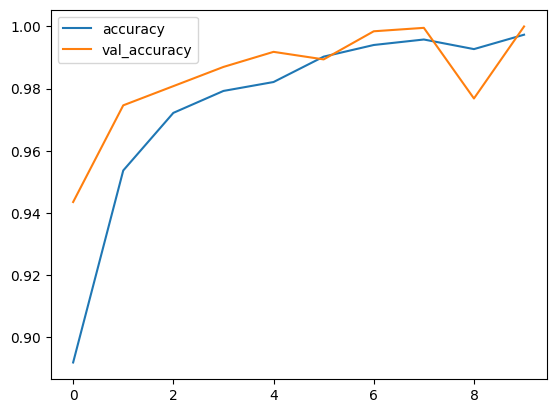

In [182]:

df = pd.DataFrame(history.history)

df[['accuracy', 'val_accuracy']].plot()

Podemos ver que mais ou menos a partir da época 7 a acurrácia diminui isso é sinal de "OVERFITTING"(O ajuste excessivo é um comportamento indesejável de aprendizado de máquina que ocorre quando o modelo de aprendizado de máquina fornece previsões precisas para dados de treinamento, mas não para novos dados.)

<Axes: >

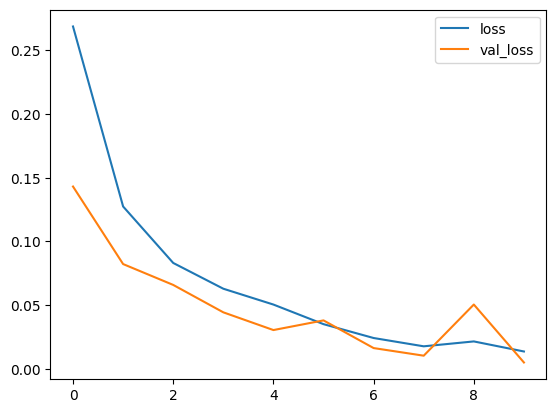

In [188]:
df[['loss', 'val_loss']].plot()

Aqui o comportamento é o esperado, o erro (loss/val_loss) dimminuindo conforme temos diferentes épocas, porém acontece overfitting na época 8

Então vamos realizar um outro treinamento com menos épocas de 10 para 7

In [192]:
modelo2 = Sequential([ base_model,
                     GlobalAveragePooling2D(),
                     Dense(1024, activation='relu'),
                     Dense(128, activation='relu'),
                     Dense(36, activation='relu'),
                     Dense(2, activation='Softmax')
])

modelo2.compile(optimizer=Adam(learning_rate=1e-4),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy']
               )


history2 = modelo2.fit(train_gen, 
           validation_data=validation_gen,
           epochs=7,
           batch_size=32,
           callbacks=[tensorBoard]
        )

Epoch 1/7
142/142 [==============================] - 22s 138ms/step - loss: 0.2898 - accuracy: 0.8872 - val_loss: 0.1723 - val_accuracy: 0.9525
Epoch 2/7
142/142 [==============================] - 18s 129ms/step - loss: 0.1482 - accuracy: 0.9455 - val_loss: 0.1085 - val_accuracy: 0.9733
Epoch 3/7
142/142 [==============================] - 18s 128ms/step - loss: 0.0983 - accuracy: 0.9647 - val_loss: 0.0801 - val_accuracy: 0.9695
Epoch 4/7
142/142 [==============================] - 18s 128ms/step - loss: 0.0648 - accuracy: 0.9792 - val_loss: 0.0435 - val_accuracy: 0.9861
Epoch 5/7
142/142 [==============================] - 18s 129ms/step - loss: 0.0460 - accuracy: 0.9863 - val_loss: 0.0314 - val_accuracy: 0.9934
Epoch 6/7
142/142 [==============================] - 18s 129ms/step - loss: 0.0353 - accuracy: 0.9874 - val_loss: 0.0210 - val_accuracy: 0.9969
Epoch 7/7
142/142 [==============================] - 18s 128ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0140 - val_accuracy:

In [193]:
pd.DataFrame(history2.history)

,loss,accuracy,val_loss,val_accuracy
0,0.289751,0.887196,0.172350,0.952539
1,0.148235,0.945475,0.108529,0.973289
2,0.098310,0.964680,0.080067,0.969536
3,0.064811,0.979249,0.043451,0.986093
4,0.045955,0.986313,0.031383,0.993378
5,0.035269,0.987417,0.021023,0.996909
6,0.025187,0.992274,0.014035,0.997572


<Axes: >

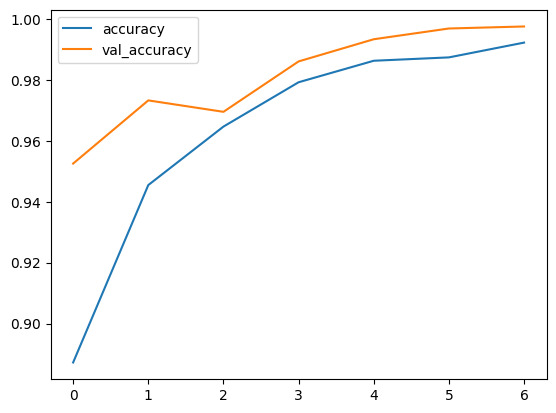

In [196]:
df2 = pd.DataFrame(history2.history)
df2[['accuracy', 'val_accuracy']].plot()

<Axes: >

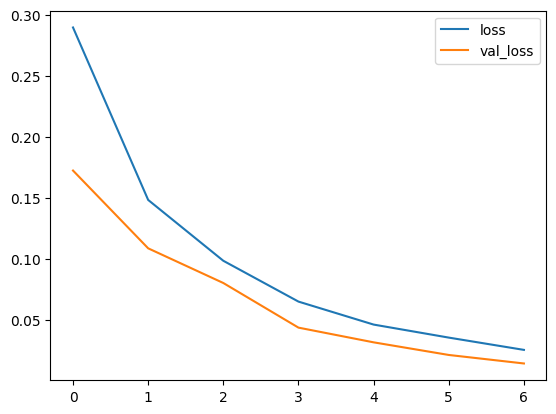

In [197]:
df2[['loss', 'val_loss']].plot()

Após feita a alteração é possível ver que o modelo se comporta claramente de uma maneira melhor, da maneira esperada

### Predições/ TESTES


In [204]:
import numpy as np

Alem de carregar a imagem eu tenho que re parametrar para meu modelo poder entender

In [275]:
def predicao(modelo, path):
    img= Image.open(path)
    img = img.resize((224,224))
    img_np=np.array(img)
    img_np = preprocess_input(img_np)
    imp_np2=img_np.reshape(1,224,224,3)
    result = modelo.predict(imp_np2)
    id_max= result[0].argmax()
    index_to_class = {v: k for k, v in train_gen.class_indices.items()}
    plt.title(f'Resultado: {index_to_class[id_max]}')
    plt.imshow(img)

### Predições com o modelo 1

1/1 [==============================] - 0s 22ms/step


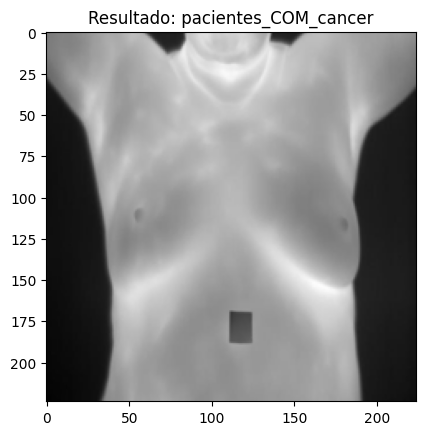

In [276]:
#TESTE DE PACIENTE COM CANCER
predicao(modelo,'DATASETS/val/pacientes_COM_cancer/T0138.2.1.D.2013-09-06.00 (1).jpg')

1/1 [==============================] - 0s 19ms/step


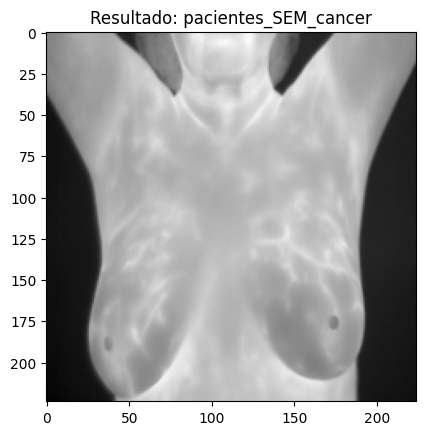

In [283]:
#TESTE DE PACIENTE SEM CANCER
predicao(modelo,'DATASETS/val/pacientes_SEM_cancer/T0002.1.1.D.2012-10-08.04 (1).jpg')

### Predições com o modelo 2

1/1 [==============================] - 0s 19ms/step


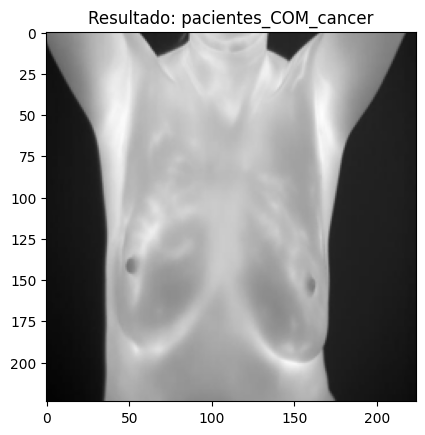

In [286]:
#TESTE DE PACIENTE COMCANCER
predicao(modelo2,'DATASETS/val/pacientes_COM_cancer/T0202.1.1.D.2013-10-11.07 (1).jpg')

1/1 [==============================] - 0s 41ms/step


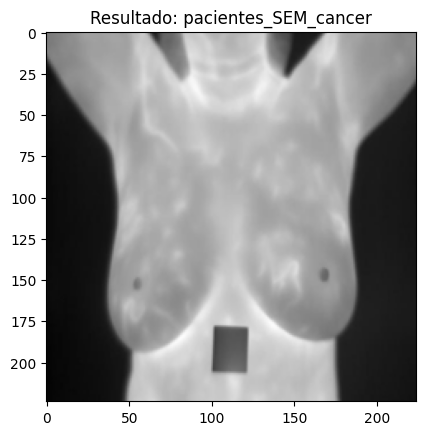

In [284]:
#TESTE DE PACIENTE SEM CANCER
predicao(modelo2,'DATASETS/val/pacientes_SEM_cancer/T0013.1.1.D.2012-10-26.18 (1).jpg')